<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/5.unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. 데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzvf /content/drive/MyDrive/annotations.tar.gz
!tar -xzvf /content/drive/MyDrive/images.tar.gz

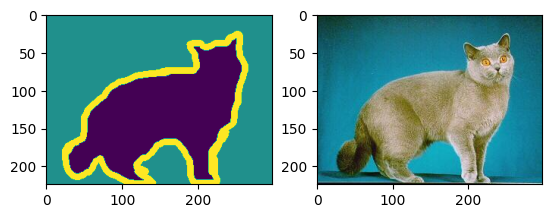

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

path_annotations = "/content/annotations/trimaps/"
path_images = "/content/images/"

annotation = Image.open(path_annotations + "British_Shorthair_9.png")
plt.subplot(1, 2, 1)
plt.imshow(annotation)

image = Image.open(path_images + "British_Shorthair_9.jpg")
plt.subplot(1, 2, 2)
plt.imshow(image)

plt.show()

## **2. 학습용 데이터**

In [ ]:
import glob
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
from PIL import Image

class Pets(Dataset):
    def __init__(self, path_images,
                 path_annotations,
                 train=True,
                 transforms=None,
                 input_size=(128, 128)):
        self.images = sorted(glob.glob(path_images + "/*.jpg"))
        self.annotations = sorted(glob.glob(path_annotations + "/*.png"))

        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]
        self.y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)

    # 이진분류: 배경0 / 경계1 / 동물1
    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0
        mask[mask == 2.0] = 0.0
        mask = torch.tensor(mask)
        return mask

    def __getitem__(self, i):
        if self.train:

            X_train = Image.open(self.X_train[i])
            # 이미지가 4채널이면 RGB 채널로 변환
            if X_train.mode == 'RGBA':
                X_train = X_train.convert('RGB')
            X_train = self.transforms(X_train)

            y_train = Image.open(self.y_train[i])
            y_train = self.preprocess_mask(y_train)

            # 이미지가 1채널이면 3채널로 확장
            if X_train.size(0) == 1:
                X_train = X_train.expand(3, -1, -1)

            return X_train, y_train
        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            y_test = Image.open(self.y_test[i])
            y_test = self.preprocess_mask(y_test)
            return X_test, y_test

## **3. 모델 정의하기**

In [ ]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        ### 인코더
        # 3 -> [] -> 64
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64,kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 64 -> [] -> 128
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128,kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 128 -> [] -> 256
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256,kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 256 -> [] -> 512
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512,kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 512 -> [] -> 512
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512,kernel_size=3, padding=1)

        ### 디코더
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool2(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)

        # 업샘플링
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1) # (B, C, H, W)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1) # (B, C, H, W)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1) # (B, C, H, W)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1) # (B, C, H, W)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x) # 흑백 이미지를 그리기 위해

        return x

## **4. 학습하기**

In [ ]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = Compose([
   Resize((128, 128)),
   ToTensor()
])

In [ ]:
train_set = Pets(path_images=path_images,
                 path_annotations=path_annotations,
                 transforms=transform)

test_set = Pets(path_images=path_images,
                 path_annotations=path_annotations,
                 transforms=transform,
                 train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

In [ ]:
model = UNet().to(device)
lr = 0.0001
optim = Adam(params=model.parameters(), lr=lr)

In [ ]:
for epoch in range(10):
    iterator = tqdm.tqdm(train_loader)

    for data, label in iterator:
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.BCEWithLogitsLoss()(
            preds,
            label.type(torch.FloatTensor).to(device)
        )
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch: {epoch+1}, loss: {loss.item()}")

torch.save(model.state_dict(),"./unet.pth")

epoch: 10, loss: 0.25330454111099243: 100%|██████████| 185/185 [01:37<00:00,  1.90it/s]


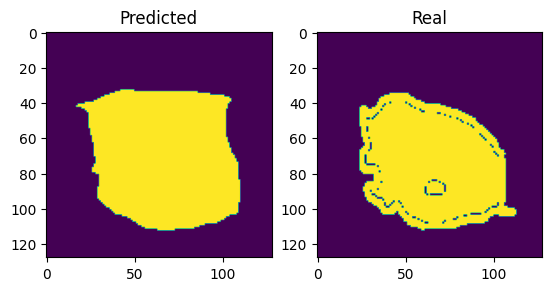

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("./unet.pth", map_location="cpu"))
data, label = test_set[800]
pred = model(torch.unsqueeze(data.to(device), dim=0))>0.5

with torch.no_grad():
   plt.subplot(1, 2, 1)
   plt.title("Predicted")
   plt.imshow(pred.cpu())
   plt.subplot(1, 2, 2)
   plt.title("Real")
   plt.imshow(label)
   plt.show()